## Final Assignment

#### Imports

In [211]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.inspection import permutation_importance


#### 2. Get the data

The following dataset is a combination of many sets from different sources found online, as it was difficult to find one dataset that would be comprehensive enough for the scale of the assignment. After a thorough research, we asked ChatGPT to combine all the information into one table and group it based on the Holmes typology. In case of missing data, certain values were added manually.

In [212]:
# Loading the data
df = pd.read_excel('SerialKiller_Dataset.xlsx')
df

,Name,Birthday,Countries Active,Years Active,Proven Victims,Possible Victims,BirthYear,StartYear,Age At The Start of Killing,Notes,Type,Nickname,Reason,Archetype/Classification,Gender,Victim Age,Victim Gender,Targeted Group Type
0,Ray Copeland,12/30/1914,United States,1986-1989,5,12,1914.0,1986.0,72.0,Ray Copeland is an American serial killer who ...,Unknown,NaN,Power,Power/Control,Male,Adult,Mixed,NaN
1,Faye Copeland,1921-04-08 00:00:00,United States,1986-1989,5,12,1921.0,1986.0,65.0,Faye Copeland (born Faye Della Wilson) is an A...,Unknown,NaN,Power,Power/Control,Female,Adult,Mixed,NaN
2,Salvatore Perrone,11/22/1948,United States,2012,3,3,1948.0,2012.0,64.0,A failing business owner and former door-to-do...,Unknown,"The Son of Sal, John Doe Duffel Bags_x000D_\n",Power,Power/Control,Male,Adult,Male,NaN
3,Viktor Fokin,2/19/1935,Russia,1996-2000,9,10+,1935.0,1996.0,61.0,"Pensioner who lured, killed and then dismember...",Hate Crime,Grandfather Ripper,Hate Crime,Mission-Oriented (Hate-Crime/Targeted Groups),Male,Adult,Female,NaN
4,Andr??Â?s P??Â?ndy,1927-01-06 00:00:00,Belgium,1986-1990,6,14+,1927.0,1986.0,59.0,"Former clergyman, killed his two wives and fou...",Unknown,Father Bluebeard,Power,Power/Control,Male,Child,Male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,Süleyman Aktaş,NaN,Turkey,1986-1994,5,5,NaN,1986.0,NaN,"In 1986, he killed police superintendent Nuri...","Hate Crime, Stangler",The Nailing Killer,Thrill,Hedonistic,Male,Adult,Male,Elderly
635,Valery Asratyan,NaN,Russia,1988-1990,3,3,NaN,1988.0,NaN,During Valery Asratyan's crimes as a serial ki...,"Financial Motive, Rapist, Sexual Predator",The Director,"Financial Gain, Sexual Assault",Hedonistic,Male,Adult,Female,NaN
636,Dmitry Baksheev,NaN,Russia,1999-2017,1,30,NaN,1999.0,NaN,"Dmitry Baksheev, and his wife Natalia Baksheev...",Cannibal,Cannibal Couple,Cannibalism,Hedonistic,Male,Adult,Female,NaN
637,Natalia Baksheev,NaN,Russia,1999-2017,1,30,NaN,1999.0,NaN,"Natalia Baksheev, and her husband Dmitry Baksh...",Cannibal,Cannibal Couple,Cannibalism,Hedonistic,Female,Adult,Female,NaN


##### Checking the size and type of data

The df.info() method was used in order to check the size and types of data in our dataset. It shows the number of entries (rows), as well as the number of columns, non-null values and the types of values in each of the columns.

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Name                         639 non-null    object 
 1   Birthday                     539 non-null    object 
 2   Countries Active             639 non-null    object 
 3   Years Active                 639 non-null    object 
 4   Proven Victims               639 non-null    object 
 5   Possible Victims             577 non-null    object 
 6   BirthYear                    575 non-null    float64
 7   StartYear                    627 non-null    float64
 8   Age At The Start of Killing  560 non-null    float64
 9   Notes                        632 non-null    object 
 10  Type                         639 non-null    object 
 11  Nickname                     431 non-null    object 
 12  Reason                       639 non-null    object 
 13  Archetype/Classifica

From the names and types of columns, we inferred that it would make sense to check for outliers in the numeric data, such as BirthYear, StartYear and Age At the Start of Killing (which was calculated using StartYear-BirthYear). 

### 3. Explore the data

#### Studying features

In [214]:
# Creating a copy of the data
df_copy = df

In [215]:
# Describing the data to get an overview of statistics, and also checking for outliers
df_copy.describe()

,BirthYear,StartYear,Age At The Start of Killing
count,575.000000,627.000000,560.000000
mean,1946.036522,1976.089314,29.794643
std,33.263813,32.439942,9.447092
min,1560.000000,1590.000000,10.000000
25%,1940.000000,1970.000000,23.000000
50%,1953.000000,1983.000000,29.000000
75%,1964.500000,1994.000000,35.000000
max,1993.000000,2018.000000,72.000000


In [216]:
# Checking the amount of total rows aka serial killers in the database
print(len(df.index))

639


Based on the minimum and maximum ages and years, it does not seem that there are any outliers (no negatives or unreasonable numbers). However, looking at the difference in counts and the fact that it did not match the total number of rows made us realize that there is missing data. Therefore, we decided to check the percentage of it.

In [217]:
# Checking the percentage of missing data
missing_percentage = df_copy.isnull().sum() / len(df_copy) * 100
print(missing_percentage)

Name                            0.000000
Birthday                       15.649452
Countries Active                0.000000
Years Active                    0.000000
Proven Victims                  0.000000
Possible Victims                9.702660
BirthYear                      10.015649
StartYear                       1.877934
Age At The Start of Killing    12.363067
Notes                           1.095462
Type                            0.000000
Nickname                       32.550861
Reason                          0.000000
Archetype/Classification        0.000000
Gender                          0.000000
Victim Age                      0.000000
Victim Gender                   0.000000
Targeted Group Type            93.427230
dtype: float64


#### Identifying the target

Since we want to be able to do criminal profiling based on the data input, the selected target was 'Archetype/Classification', as it would help the police classify the type of criminal based on the amount and type of killings, as well as their victim profile.

In [218]:
y = df_copy['Archetype/Classification']

### 4. Prepare the data

#### Dropping unnnecessary features

We decided to drop Name, Notes and Nickname as they did not provide any valuable information. Additionally, we got rid of Birthday, as it held too many different types of data formats.

In [219]:
columns_to_drop = ['Name', 'Birthday', 'Notes', 'Nickname']
df_cleaned = df_copy.drop(columns=columns_to_drop)
df_cleaned
print(df_cleaned.columns)


Index(['Countries Active', 'Years Active', 'Proven Victims',
       'Possible Victims', 'BirthYear', 'StartYear',
       'Age At The Start of Killing', 'Type', 'Reason',
       'Archetype/Classification', 'Gender', 'Victim Age', 'Victim Gender',
       'Targeted Group Type'],
      dtype='object')


In [220]:
# Removing spacing in column names to ensure there are no mismatches
df_cleaned.columns = df_cleaned.columns.str.replace(' ', '')

# Dropping NaNs
df_cleaned = df_cleaned.dropna(subset=['AgeAtTheStartofKilling'])
df_cleaned = df_cleaned.dropna(subset=['StartYear'])
df_cleaned = df_cleaned.dropna(subset=['BirthYear'])



In [221]:
# Confirming that there are no more NaNs in the columns
print(df_cleaned['AgeAtTheStartofKilling'].isna().sum())
print(df_cleaned['StartYear'].isna().sum())
print(df_cleaned['BirthYear'].isna().sum())

0
0
0


### Cleaning Values

In [222]:
# Define the specific datetime values to check
datetime_2015 = datetime(2015, 8, 1, 0, 0)
datetime_2016 = datetime(2016, 11, 1, 0, 0)
datetime_2013= datetime(2013, 9, 1, 0, 0)

df_regression = df_cleaned.copy()


# Count occurrences of both datetime values
combined_count = df_regression['ProvenVictims'].apply(
    lambda x: x in [datetime_2015, datetime_2016, datetime_2013]
).sum()

# Print the combined count
print(f"Occurrences of {datetime_2015} and {datetime_2016} and {datetime_2013}: {combined_count}")

# Remove rows with specific datetime values from the 'Proven Victims' column
df_regression_cleaned = df_regression[
    ~df_regression['ProvenVictims'].apply(
        lambda x: x in [datetime(2015, 8, 1, 0, 0), datetime(2016, 11, 1, 0, 0), datetime(2013, 9, 1, 0, 0)]
    )
]
# Replace the value '103+' with '103' in the 'Proven Victims' column
df_regression_cleaned['ProvenVictims'] = df_regression_cleaned['ProvenVictims'].replace('103+', 103)
df_regression_cleaned['ProvenVictims'] = df_regression_cleaned['ProvenVictims'].replace('18+', 18)
df_regression_cleaned['ProvenVictims'] = df_regression_cleaned['ProvenVictims'].replace('8-11+', 11)


Occurrences of 2015-08-01 00:00:00 and 2016-11-01 00:00:00 and 2013-09-01 00:00:00: 3


C:\Users\aleja\AppData\Local\Temp\ipykernel_316\2498463925.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_regression_cleaned['ProvenVictims'] = df_regression_cleaned['ProvenVictims'].replace('103+', 103)
C:\Users\aleja\AppData\Local\Temp\ipykernel_316\2498463925.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression_cleaned['ProvenVictims'] = df_regression_cleaned['ProvenVictims'].replace('103+', 103)
C:\Users\aleja\AppData\Local\Temp\ipykernel_316\2498463925.py:25: SettingWithCopyWarning: 
A value

#### Study correlations between features

In [223]:
# Create a copy of the DataFrame to avoid modifying the original
encoded_df = df_regression_cleaned.copy()

# Apply LabelEncoder to each non-numeric column
for column in encoded_df.select_dtypes(include=['object']).columns:
    encoded_df[column] = encoded_df[column].astype(str)  # Convert to string
    encoded_df[column] = LabelEncoder().fit_transform(encoded_df[column])

# Perform correlation
correlation_matrix = encoded_df.corr()
correlation_matrix


,CountriesActive,YearsActive,ProvenVictims,PossibleVictims,BirthYear,StartYear,AgeAtTheStartofKilling,Type,Reason,Archetype/Classification,Gender,VictimAge,VictimGender,TargetedGroupType
CountriesActive,1.000000,-0.052370,-0.158337,0.076611,0.005076,-0.003466,-0.029994,-0.024835,-0.003394,0.016452,-0.105227,-0.050387,0.029822,-0.079505
YearsActive,-0.052370,1.000000,-0.006971,0.016010,0.754607,0.817247,0.159445,-0.084391,0.045720,-0.043418,0.072015,-0.136262,-0.009504,-0.108658
ProvenVictims,-0.158337,-0.006971,1.000000,-0.021103,-0.076065,-0.077700,0.000147,-0.095570,-0.013719,0.043595,0.051458,0.104754,0.031319,0.015505
PossibleVictims,0.076611,0.016010,-0.021103,1.000000,0.027012,0.007428,-0.069940,0.039551,0.077079,-0.074866,0.072048,0.007680,-0.039381,0.029306
BirthYear,0.005076,0.754607,-0.076065,0.027012,1.000000,0.959513,-0.216735,-0.014152,0.112304,-0.025568,0.143865,-0.149608,0.010860,-0.071874
StartYear,-0.003466,0.817247,-0.077700,0.007428,0.959513,1.000000,0.067009,-0.019828,0.095221,-0.023031,0.129403,-0.170360,-0.000781,-0.072667
AgeAtTheStartofKilling,-0.029994,0.159445,0.000147,-0.069940,-0.216735,0.067009,1.000000,-0.018592,-0.067790,0.010749,-0.061119,-0.060494,-0.041176,0.002744
Type,-0.024835,-0.084391,-0.095570,0.039551,-0.014152,-0.019828,-0.018592,1.000000,0.274255,0.540178,0.011747,0.052620,0.083615,0.322010
Reason,-0.003394,0.045720,-0.013719,0.077079,0.112304,0.095221,-0.067790,0.274255,1.000000,-0.207695,0.086808,0.057726,0.127969,0.026426
Archetype/Classification,0.016452,-0.043418,0.043595,-0.074866,-0.025568,-0.023031,0.010749,0.540178,-0.207695,1.000000,-0.106019,0.022012,0.253819,-0.062435


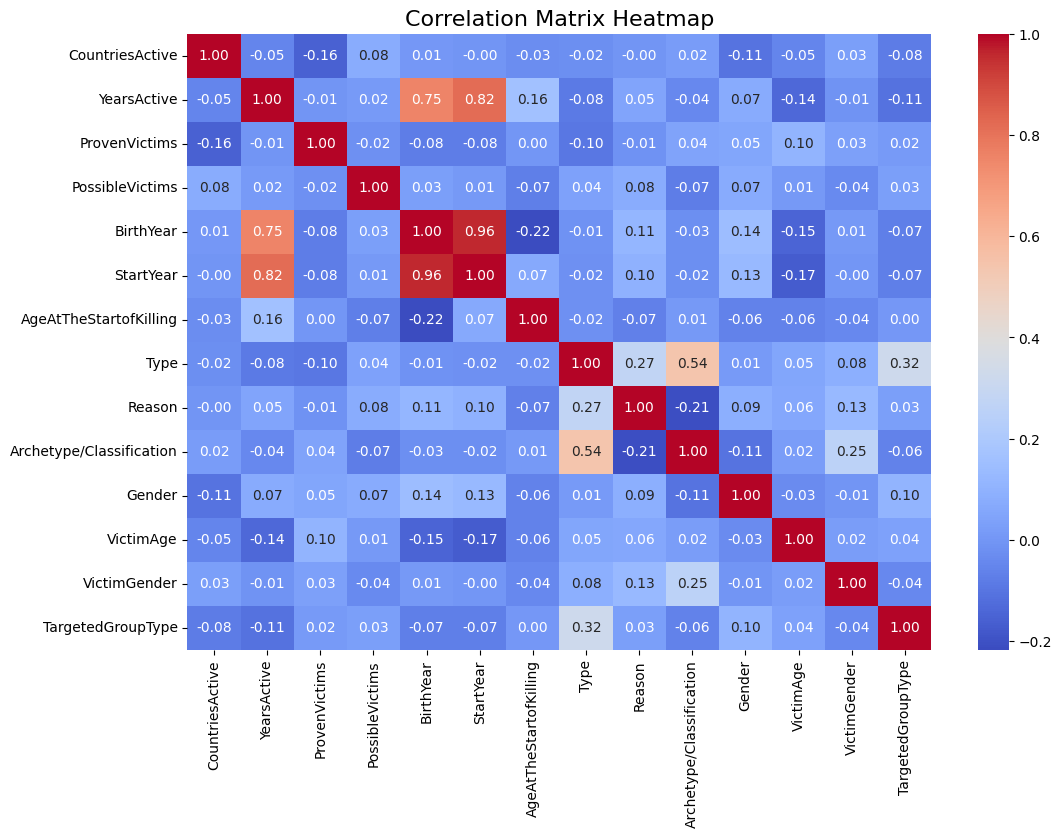

In [224]:
plt.figure(figsize=(12, 8))  
sns.heatmap(correlation_matrix, 
            annot=True,        
            fmt=".2f",         
            cmap="coolwarm",  
            cbar=True)         
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()

In [225]:
# Assesing archetypes
unique_archetypes = df_regression_cleaned['Archetype/Classification'].unique()
print(unique_archetypes)

['Power/Control' 'Mission-Oriented (Hate-Crime/Targeted Groups)'
 'Hedonistic - Lust' 'Hedonistic' 'Power and Hedonistic' 'Visionary'
 'Hedonistic - Thrill' 'Hate Crime']


In [226]:
# Filtering rows where the updated value is 'Hedonistic'
hedonistic_rows = df_regression_cleaned[df_regression_cleaned['Archetype/Classification'] == 'Hedonistic']
hedonistic_rows

,CountriesActive,YearsActive,ProvenVictims,PossibleVictims,BirthYear,StartYear,AgeAtTheStartofKilling,Type,Reason,Archetype/Classification,Gender,VictimAge,VictimGender,TargetedGroupType
6,Czech Republic,1948-1951,5,10,1891.0,1948.0,57.0,"Financial Motive, Rapist, Sexual Predator","Financial Gain, Sexual Assault",Hedonistic,Male,Adult,Male,NaN
9,Czechoslovakia,1948-1951,5,10+,1891.0,1948.0,57.0,Financial Motive,Financial Gain,Hedonistic,Male,Adult,Male,NaN
12,Belgium,1933-1936,11,NaN,1879.0,1933.0,54.0,Unknown,Financial Gain,Hedonistic,Male,Adult,Mixed,NaN
16,Austria,1981-1995,3,10+,1931.0,1981.0,50.0,"Financial Motive, Medical",Financial Gain,Hedonistic,Male,Adult,Mixed,NaN
22,Russia,1995-2015,13,13+,1947.0,1995.0,48.0,Cannibal,Cannibalism,Hedonistic,Female,Adult,Male,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,United States,1961-1983,6,108,1947.0,1961.0,14.0,Cannibal,Cannibalism,Hedonistic,Male,Adult,Mixed,NaN
514,Brazil,1967-2003,71,100+,1954.0,1967.0,13.0,"Cannibal, Cannibal, Torturer",Cannibalism,Hedonistic,Male,Adult,Mixed,NaN
527,Soviet Union,1945-1946,14,29,1910.0,1945.0,35.0,Financial Motive,Financial Gain,Hedonistic,Male,Adult,Mixed,NaN
550,China,2008-2012,11,17-20,1956.0,2008.0,52.0,"Cannibal, Cannibal, Strangler",Cannibalism,Hedonistic,Male,Adult,Mixed,NaN


In [227]:
# Renaming archetypes to match the 4 relevant types mentioned in our research
df_regression_cleaned['Archetype/Classification'] = df_regression_cleaned['Archetype/Classification'].replace('Hedonistic - Lust', 'Hedonistic')
df_regression_cleaned['Archetype/Classification'] = df_regression_cleaned['Archetype/Classification'].replace('Hedonistic - Thrill', 'Hedonistic')
df_regression_cleaned['Archetype/Classification'] = df_regression_cleaned['Archetype/Classification'].replace('Profit Killer', 'Hedonistic')
df_regression_cleaned['Archetype/Classification'] = df_regression_cleaned['Archetype/Classification'].replace('Hate Crime', 'Missionary')
df_regression_cleaned['Archetype/Classification'] = df_regression_cleaned['Archetype/Classification'].replace('Mission-Oriented (Hate-Crime/Targeted Groups)', 'Missionary')


# Verifying the change
unique_archetypes = df_regression_cleaned['Archetype/Classification'].unique()
print(unique_archetypes)


['Power/Control' 'Missionary' 'Hedonistic' 'Power and Hedonistic'
 'Visionary']


C:\Users\aleja\AppData\Local\Temp\ipykernel_316\4115579495.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression_cleaned['Archetype/Classification'] = df_regression_cleaned['Archetype/Classification'].replace('Hedonistic - Lust', 'Hedonistic')
C:\Users\aleja\AppData\Local\Temp\ipykernel_316\4115579495.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression_cleaned['Archetype/Classification'] = df_regression_cleaned['Archetype/Classification'].replace('Hedonistic - Thrill', 'Hedonistic'

In [228]:

# Filtering rows where the updated value is 'Hedonistic'
hedonistic_rows = df_regression_cleaned[df_regression_cleaned['Archetype/Classification'] == 'Power/Control']
hedonistic_rows

# Remove 'Hate Crime,' from the 'Type' column
df_regression_cleaned['Type'] = df_regression_cleaned['Type'].str.replace('Hate Crime, Medical', 'Medical', regex=False).str.strip()

# Verify the change
print(df_regression_cleaned['Type'].unique())



['Unknown' 'Hate Crime' 'Hate Crime, Rapist, Sexual Predator'
 'Financial Motive, Rapist, Sexual Predator' 'Rapist, Sexual Predator'
 'Financial Motive' 'Torturer'
 'Cannibal, Pedophile, Rapist, Vampire, Cannibal, Torturer, Stalker, Sexual Predator, Vampire'
 'Financial Motive, Medical' 'Rapist, Stalker, Sexual Predator'
 'Rapist, Necrophiliac, Strangler, Sexual Predator'
 'Rapist, Strangler, Sexual Predator' 'Cannibal' 'Hate Crime, Strangler'
 'Rapist, Strangler, Pedophile, Sexual Predator'
 'Rapist, Torturer, Strangler, Sexual Predator' 'Sexual Predator'
 'Rapist, Pedophile, Strangler, Sexual Predator'
 'Financial Motive, Hate Crime'
 'Financial Motive, Medical, Rapist, Torturer, Sexual Predator'
 'Financial Motive, Rapist, Torturer, Strangler, Sexual Predator'
 'Cannibal, Necrophiliac, Cannibal, Rapist, Sexual Predator'
 'Serial Killer, Rapist, Strangler, Vampire, Sexual Predator, Vampire'
 'Rapist, Torturer, Sexual Predator'
 'Rapist, Torturer, Strangler, Stalker, Sexual Predator'


C:\Users\aleja\AppData\Local\Temp\ipykernel_316\2355039924.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression_cleaned['Type'] = df_regression_cleaned['Type'].str.replace('Hate Crime, Medical', 'Medical', regex=False).str.strip()


In [229]:
# Filter rows where the updated value is 'Hedonistic'
hedonistic_rows = df_regression_cleaned[df_regression_cleaned['Archetype/Classification'] == 'Power and Hedonistic']
df_regression_cleaned['Archetype/Classification'] = df_regression_cleaned['Archetype/Classification'].replace('Power and Hedonistic', 'Power/Control')
df_regression_cleaned['Archetype/Classification'] = df_regression_cleaned['Archetype/Classification'].replace('Power', 'Power/Control')
# Filter rows where the updated value is 'Hedonistic'
hedonistic_rows = df_regression_cleaned[df_regression_cleaned['Archetype/Classification'] == 'Visionary']
hedonistic_rows


C:\Users\aleja\AppData\Local\Temp\ipykernel_316\201771856.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression_cleaned['Archetype/Classification'] = df_regression_cleaned['Archetype/Classification'].replace('Power and Hedonistic', 'Power/Control')
C:\Users\aleja\AppData\Local\Temp\ipykernel_316\201771856.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression_cleaned['Archetype/Classification'] = df_regression_cleaned['Archetype/Classification'].replace('Power', 'Power/Control')


,CountriesActive,YearsActive,ProvenVictims,PossibleVictims,BirthYear,StartYear,AgeAtTheStartofKilling,Type,Reason,Archetype/Classification,Gender,VictimAge,VictimGender,TargetedGroupType
49,Canada,1963,4,4,1920.0,1963.0,43.0,Unknown,Mental Illness,Visionary,Male,Adult,Male,NaN
130,United Kingdom,1944-1949,6,9,1909.0,1944.0,35.0,Vampire,Religious,Visionary,Male,Adult,Mixed,NaN
150,United States,1996-1997,6,6,1962.0,1996.0,34.0,Visionary,Mental Illness,Visionary,Male,Adult,Mixed,Elderly
310,United States,1981-1986,4,7,1955.0,1981.0,26.0,Unknown,Religious,Visionary,Male,Child,Mixed,NaN
320,United States,1972-1973,13,NaN,1947.0,1972.0,25.0,Unknown,Mental Illness,Visionary,Male,Adult,Male,NaN
387,United Kingdom,1888-1891,5,11,1865.0,1888.0,23.0,Unknown,Mental Illness,Visionary,Male,Adult,Mixed,NaN
538,Russia,2004-2006,13,NaN,1956.0,2004.0,48.0,Unknown,Mental Illness,Visionary,Male,Adult,Male,NaN
573,Colombia,2002-2018,7,10,1971.0,2002.0,31.0,Unknown,Occult Ritual,Visionary,Male,Adult,Mixed,NaN


In [230]:

# Verify the change
unique_archetypes = df_regression_cleaned['Archetype/Classification'].unique()
print(unique_archetypes)
hedonistic_rows = df_regression_cleaned[df_regression_cleaned['Archetype/Classification'] == 'Power/Control - Lust']
hedonistic_rows
df_regression_cleaned['Archetype/Classification'] = df_regression_cleaned['Archetype/Classification'].replace('Power/Control - Lust', 'Power/Control')
# Verify the change
unique_archetypes = df_regression_cleaned['Archetype/Classification'].unique()
print(unique_archetypes)



['Power/Control' 'Missionary' 'Hedonistic' 'Visionary']
['Power/Control' 'Missionary' 'Hedonistic' 'Visionary']


C:\Users\aleja\AppData\Local\Temp\ipykernel_316\2459817017.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_regression_cleaned['Archetype/Classification'] = df_regression_cleaned['Archetype/Classification'].replace('Power/Control - Lust', 'Power/Control')


### Logistic Regression

In [231]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Preparing the data

# Define the columns to keep
selected_columns = ["CountriesActive", "AgeAtTheStartofKilling",
                    "Reason", "Archetype/Classification", "Gender", "VictimAge", 
                    "VictimGender", "TargetedGroupType", "ProvenVictims"]

# Create a subset of df_regression_cleaned with only the selected columns
df_regression_limited = df_regression_cleaned[selected_columns].copy()

# Ensure all columns with lists are converted to strings
columns_with_lists = ['CountriesActive', 'Reason', 'Gender', 'VictimGender', 'TargetedGroupType', 'VictimAge']
for col in columns_with_lists:
    df_regression_limited[col] = df_regression_limited[col].apply(lambda x: ','.join(x) if isinstance(x, list) else x)

# Encode the target column `Archetype/Classification` with LabelEncoder
label_encoder = LabelEncoder()
df_regression_limited['Archetype/Classification'] = label_encoder.fit_transform(df_regression_limited['Archetype/Classification'])

# Label-encode remaining categorical columns to ensure all data is numeric
for col in ['VictimAge', 'CountriesActive', 'Reason', 'Gender', 'VictimGender', 'TargetedGroupType']:
    if df_regression_limited[col].dtype == 'object':
        le = LabelEncoder()
        df_regression_limited[col] = le.fit_transform(df_regression_limited[col])

# Define features (X) and target (y)
X = df_regression_limited.drop(columns=['Archetype/Classification'])
y = df_regression_limited['Archetype/Classification']

# Split data into training (80%) and remaining (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Divide the remaining 20% equally into test and validation sets (10% each of the total data)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the sizes of each dataset to confirm
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Logistic Regression with class balancing
log_reg = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

# Predictions
train_predictions = log_reg.predict(X_train_scaled)
test_predictions = log_reg.predict(X_test_scaled)
val_predictions = log_reg.predict(X_val_scaled)

# Performance Metrics Function for Classification
def print_classification_metrics(y_true, y_pred, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{dataset_name} Performance:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Macro F1 Score: {macro_f1:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\n")

# Print Metrics
print_classification_metrics(y_train, train_predictions, "Training")
print_classification_metrics(y_test, test_predictions, "Testing")
print_classification_metrics(y_val, val_predictions, "Validation")


Training set size: 445
Testing set size: 56
Validation set size: 56
Training Performance:
Accuracy: 0.60
Macro F1 Score: 0.44

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.69      0.77       264
           1       0.18      0.93      0.30        14
           2       0.69      0.41      0.52       161
           3       0.09      1.00      0.16         6

    accuracy                           0.60       445
   macro avg       0.46      0.76      0.44       445
weighted avg       0.77      0.60      0.65       445


Confusion Matrix:
[[181  25  28  30]
 [  0  13   1   0]
 [ 28  34  66  33]
 [  0   0   0   6]]


Testing Performance:
Accuracy: 0.61
Macro F1 Score: 0.43

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.70      0.79        33
           1       0.22      1.00      0.36         2
           2       0.75      0.45      0.56        20
           3       

#### Random Forest

Random Forest is an algorythm used for classification and regression tasks. It handles both numerical and categorical data, fitting our dataset best. We decided it would work best when classifying serial killers into predefined archetypes accurately.

In [232]:
# Importing required libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Preparing the data
# Encoding the target column (Archetype/Classification) and features
df_encoded = df_cleaned.copy()

# Label encoding categorical columns (features)
label_encoder = LabelEncoder()
for column in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column].astype(str))

# Defining the features (X) and target variable (y)
X = df_encoded.drop(columns=['Archetype/Classification'])  
y = df_encoded['Archetype/Classification']  

# Splitting the data into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Splitting temp into test (10%) and validation (10%)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Checking the sizes of the splits
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))
print("Validation set size:", len(X_val))

# Initializing the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Tracking the accuracy
num_trees = [10, 50, 100, 200]  # Number of trees in each iteration
train_accuracies = []
test_accuracies = []

# Training loop
for n in num_trees:
    print(f"\nTraining Random Forest with {n} trees...")
    
    # Updating the model with the current number of trees
    rf_model.set_params(n_estimators=n)
    
    # Training the model
    rf_model.fit(X_train, y_train)
    
    # Predicting on the training set and test set
    train_predictions = rf_model.predict(X_train)
    test_predictions = rf_model.predict(X_test)
    
    # Calculating accuracy
    train_acc = accuracy_score(y_train, train_predictions)
    test_acc = accuracy_score(y_test, test_predictions)
    
    # Saving the accuracies
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    print(f"Train Accuracy: {train_acc:.2f}")
    print(f"Test Accuracy: {test_acc:.2f}")

# Predicting on the validation set
validation_predictions = rf_model.predict(X_val)

# Calculating accuracy
validation_accuracy = accuracy_score(y_val, validation_predictions)
print(f"\nFinal Validation Accuracy: {validation_accuracy:.2f}")

Training set size: 448
Testing set size: 56
Validation set size: 56

Training Random Forest with 10 trees...


Train Accuracy: 1.00
Test Accuracy: 0.88

Training Random Forest with 50 trees...
Train Accuracy: 1.00
Test Accuracy: 0.88

Training Random Forest with 100 trees...
Train Accuracy: 1.00
Test Accuracy: 0.88

Training Random Forest with 200 trees...
Train Accuracy: 1.00
Test Accuracy: 0.88

Final Validation Accuracy: 0.98


### Gradient Boosted Tree

In [233]:
# Preparing the data
# Encoding the target column (Archetype/Classification) and features
df_encode_GB = df_cleaned.copy()

# Label encoding categorical columns (features)
label_encoder = LabelEncoder()
for column in df_encode_GB.select_dtypes(include=['object']).columns:
    df_encode_GB[column] = label_encoder.fit_transform(df_encode_GB[column].astype(str))

# Dropping the 'Victim Age' column as it does not contribute to model performance
df_encode_GB = df_encode_GB.drop(columns=['Gender', 'VictimAge'])

# Defining the features (X) and target variable (y)
X_GB = df_encode_GB.drop(columns=['Archetype/Classification'])  
y_GB = df_encode_GB['Archetype/Classification']  

# Splitting the data into train (80%) and temp (20%)
X_train_GB, X_temp_GB, y_train_GB, y_temp_GB = train_test_split(X_GB, y_GB, test_size=0.2, random_state=42)

# Splitting temp into test (10%) and validation (10%)
X_test_GB, X_val_GB, y_test_GB, y_val_GB = train_test_split(X_temp_GB, y_temp_GB, test_size=0.5, random_state=42)

# Checking the sizes of the splits
print("Training set size:", len(X_train_GB))
print("Testing set size:", len(X_test_GB))
print("Validation set size:", len(X_val_GB))

warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")


# Initializing the Gradient Boosted Tree model
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Tracking the accuracy
learning_rates = [0.01, 0.1, 0.2, 0.3]  # Different learning rates
train_accuracies = []
test_accuracies = []

# Training loop
for lr in learning_rates:
    print(f"\nTraining Gradient Boosted Tree with learning rate {lr}...")
    
    # Updating the model with the current learning rate
    xgb_model.set_params(learning_rate=lr)
    
    # Training the model
    xgb_model.fit(X_train_GB, y_train_GB)   
    
    # Predicting on the training set and test set
    train_predictions = xgb_model.predict(X_train_GB)
    test_predictions = xgb_model.predict(X_test_GB)
    
    # Calculating accuracy
    train_acc_GB = accuracy_score(y_train_GB, train_predictions)
    test_acc_GB = accuracy_score(y_test_GB, test_predictions)
    
    # Saving the accuracies
    train_accuracies.append(train_acc_GB)
    test_accuracies.append(test_acc_GB)
    
    print(f"Train Accuracy: {train_acc_GB:.2f}")
    print(f"Test Accuracy: {test_acc_GB:.2f}")

# Predicting on the validation set
validation_predictions_GB = xgb_model.predict(X_val_GB)

# Calculating accuracy
validation_accuracy_GB = accuracy_score(y_val_GB, validation_predictions_GB)
print(f"\nFinal Validation Accuracy: {validation_accuracy_GB:.2f}")

# Analyzing feature importance
importances_GB = xgb_model.feature_importances_
feature_importance_GB = sorted(zip(X_GB.columns, importances_GB), key=lambda x_GB: x_GB[1], reverse=True)

print("\nFeature Importance:")
for feature_GB, importance_GB in feature_importance_GB:
    print(f"{feature_GB}: {importance_GB:.4f}")


Training set size: 448
Testing set size: 56
Validation set size: 56

Training Gradient Boosted Tree with learning rate 0.01...
Train Accuracy: 0.99
Test Accuracy: 0.91

Training Gradient Boosted Tree with learning rate 0.1...
Train Accuracy: 1.00
Test Accuracy: 0.95

Training Gradient Boosted Tree with learning rate 0.2...
Train Accuracy: 1.00
Test Accuracy: 0.95

Training Gradient Boosted Tree with learning rate 0.3...
Train Accuracy: 1.00
Test Accuracy: 0.93

Final Validation Accuracy: 0.98

Feature Importance:
Reason: 0.5788
Type: 0.2298
StartYear: 0.0460
ProvenVictims: 0.0273
PossibleVictims: 0.0233
TargetedGroupType: 0.0202
AgeAtTheStartofKilling: 0.0189
BirthYear: 0.0159
CountriesActive: 0.0157
YearsActive: 0.0138
VictimGender: 0.0102


In [234]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Setting up the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Setting up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Fitting the model
grid_search.fit(X_train_GB, y_train_GB)

# Best parameters and best score
print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluating the best model on the validation set
best_model_GB = grid_search.best_estimator_
validation_predictions_GB = best_model_GB.predict(X_val_GB)
validation_accuracy_GB = accuracy_score(y_val_GB, validation_predictions_GB)
print(f"\nFinal Validation Accuracy: {validation_accuracy_GB:.2f}")

# Analyzing feature importance
importances_GB = best_model_GB.feature_importances_
feature_importance_GB = sorted(zip(X_GB.columns, importances_GB), key=lambda x_GB: x_GB[1], reverse=True)

print("\nFeature Importance:")
for feature_GB, importance_GB in feature_importance_GB:
    print(f"{feature_GB}: {importance_GB:.4f}")

Fitting 3 folds for each of 144 candidates, totalling 432 fits


c:\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best Cross-Validation Accuracy: nan

Final Validation Accuracy: 0.98

Feature Importance:
Reason: 0.3767
VictimGender: 0.2939
Type: 0.2355
TargetedGroupType: 0.0209
AgeAtTheStartofKilling: 0.0193
YearsActive: 0.0136
PossibleVictims: 0.0134
BirthYear: 0.0082
ProvenVictims: 0.0075
StartYear: 0.0066
CountriesActive: 0.0043


c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
144 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6], got [1 2 

In [235]:
# Suppressing specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

# Evaluating the model on the test set
test_predictions_GB = best_model_GB.predict(X_test_GB)
test_accuracy_GB = accuracy_score(y_test_GB, test_predictions_GB)
print(f"\nFinal Test Accuracy: {test_accuracy_GB:.2f}")

# Error Analysis
print("\nClassification Report:")
print(classification_report(y_test_GB, test_predictions_GB))

# Extracting feature names from feature_importance
features_GB = [feature_GB for feature_GB, importance_GB in feature_importance_GB]

# Summary of Findings
summary_GB = f'''
Model Performance Summary:
- Best Hyperparameters: {grid_search.best_params_}
- Validation Accuracy: {validation_accuracy_GB:.2f}
- Test Accuracy: {test_accuracy_GB:.2f}

Error Analysis:
- See Classification Report for detailed insights.

Feature Importance:
- Top Features:
  {', '.join(features_GB[:5])}
'''
print(summary_GB)



Final Test Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.86      0.86      0.86         7
           2       0.95      0.95      0.95        22
           4       0.60      1.00      0.75         3
           5       1.00      1.00      1.00         2
           6       0.90      0.95      0.92        19
           7       0.00      0.00      0.00         2

    accuracy                           0.89        56
   macro avg       0.62      0.68      0.64        56
weighted avg       0.86      0.89      0.87        56


Model Performance Summary:
- Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
- Validation Accuracy: 0.98
- Test Accuracy: 0.89

Error Analysis:
- See Classification Report for detailed insights.

Feature Importance:
- Top Features:
  Reason, VictimGender, Type, TargetedGrou

c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Neural Network

In [236]:
# Preparing the data
df_nn = df_regression_cleaned.copy()

# Encode categorical columns (features and target)
label_encoder = LabelEncoder()
for column in df_nn.select_dtypes(include=['object']).columns:
    df_nn[column] = label_encoder.fit_transform(df_nn[column].astype(str))

# Separate features and target
X_nn = df_nn.drop(columns=['Archetype/Classification'])  # Features
y_nn = df_nn['Archetype/Classification']  # Target

# Use SMOTE to balance the dataset 
smote = SMOTE(random_state=42, k_neighbors=1, sampling_strategy="auto")
X_resampled, y_resampled = smote.fit_resample(X_nn, y_nn)

# Scaling the features
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Splitting the balanced and scaled data into train, temp (test + validation)
X_train_nn, X_temp_nn, y_train_nn, y_temp_nn = train_test_split(
    X_resampled_scaled, y_resampled,
    test_size=0.2, 
    random_state=42,
    stratify=y_resampled # Maintain the class distribution
)

# Splitting temp into test and validation
X_test_nn, X_val_nn, y_test_nn, y_val_nn = train_test_split(
    X_temp_nn, y_temp_nn,
    test_size=0.5,  # Split the temp set equally into test and validation
    random_state=42,
    stratify=y_temp_nn 
)

# One-hot encoding for target variables after splitting
y_train_nn_encoded = pd.get_dummies(y_train_nn)
y_val_nn_encoded = pd.get_dummies(y_val_nn)
y_test_nn_encoded = pd.get_dummies(y_test_nn)


# Building the Neural Network
def create_nn_model(learning_rate=0.001, dropout_rate=0.3):
    model = Sequential([
        Dense(128, input_dim=X_train_nn.shape[1], activation='relu'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(y_train_nn_encoded.shape[1], activation='softmax')  # Output layer matches the number of classes
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',  # Categorical cross-entropy loss for multi-class
                  metrics=['accuracy'])
    return model

# Initialize and train the model
nn_model = create_nn_model(learning_rate=0.001, dropout_rate=0.3)

history = nn_model.fit(
    X_train_nn, y_train_nn_encoded,  # Use one-hot encoded labels for training
    validation_data=(X_val_nn, y_val_nn_encoded),  # Use one-hot encoded labels for validation
    epochs=50,
    batch_size=32,
    verbose=1
)


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.3571 - loss: 1.3370 - val_accuracy: 0.8527 - val_loss: 0.9310
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7185 - loss: 0.9492 - val_accuracy: 0.8295 - val_loss: 0.6250
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8155 - loss: 0.6767 - val_accuracy: 0.9225 - val_loss: 0.4304
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8691 - loss: 0.5088 - val_accuracy: 0.9225 - val_loss: 0.3254
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8506 - loss: 0.4692 - val_accuracy: 0.9380 - val_loss: 0.2611
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8921 - loss: 0.3738 - val_accuracy: 0.9380 - val_loss: 0.2264
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8947 - loss: 0.3583 - val_accuracy: 0.9380 - val_loss: 0.2014
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8945 - loss: 0.3080 - val_accuracy: 0.9535 - val_loss


Neural Network Test Accuracy: 0.98


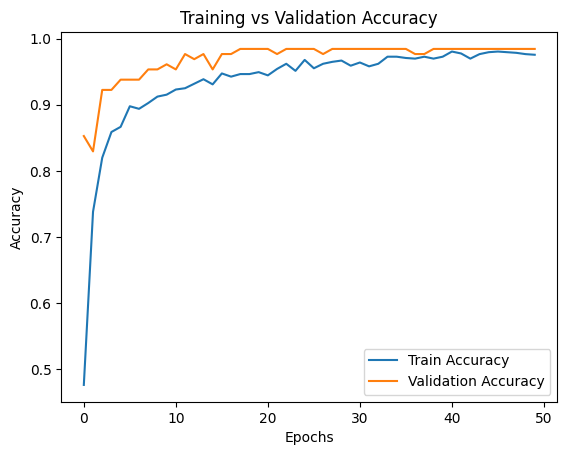

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


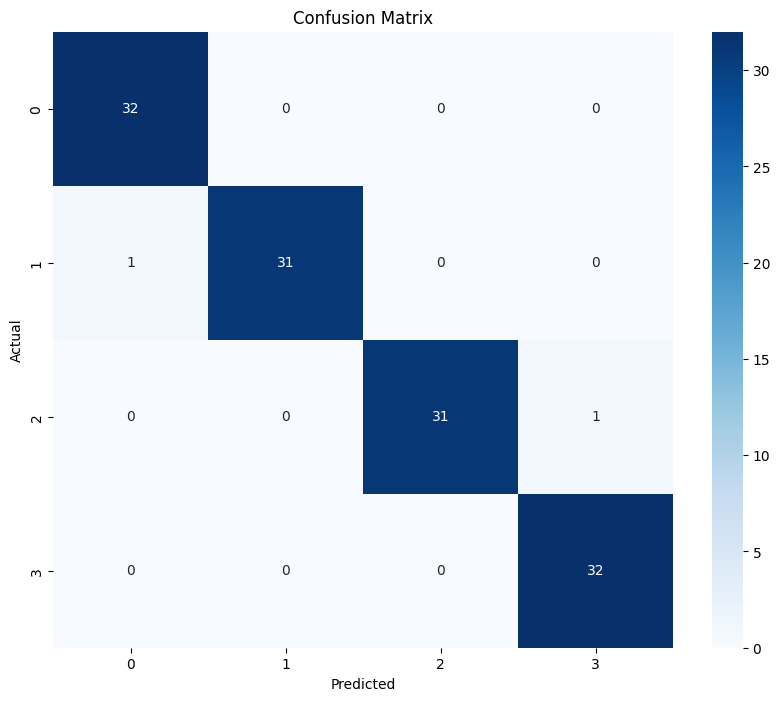

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        32
           1       1.00      0.97      0.98        32
           2       1.00      0.97      0.98        32
           3       0.97      1.00      0.98        32

    accuracy                           0.98       128
   macro avg       0.98      0.98      0.98       128
weighted avg       0.98      0.98      0.98       128

Top Important Features:
                   Feature  Importance
8                   Reason    0.322656
7                     Type    0.321875
11            VictimGender    0.232813
12       TargetedGroupType    0.103906
3          PossibleVictims    0.099219
0          CountriesActive    0.073438
1              YearsActive    0.060937
5                StartYear    0.048438
9                   Gender    0.045312
6   AgeAtTheStartofKilling    0.041406


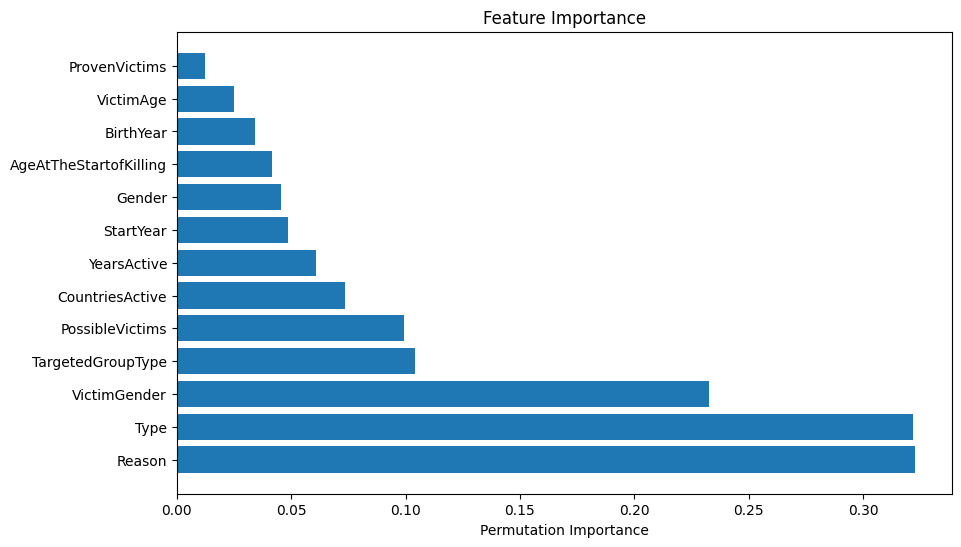

In [237]:
# One-hot encode the labels once
y_train_nn_encoded = to_categorical(y_train_nn, num_classes=4)
y_val_nn_encoded = to_categorical(y_val_nn, num_classes=4)
y_test_nn_encoded = to_categorical(y_test_nn, num_classes=4)

# Evaluate the model on the test set
test_loss, test_accuracy = nn_model.evaluate(X_test_nn, y_test_nn_encoded, verbose=0)
print(f"\nNeural Network Test Accuracy: {test_accuracy:.2f}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Confusion Matrix
nn_test_predictions = np.argmax(nn_model.predict(X_test_nn), axis=1)
conf_matrix = confusion_matrix(y_test_nn, nn_test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(nn_test_predictions), yticklabels=np.unique(nn_test_predictions))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_nn, nn_test_predictions))

# Permutation Feature Importance
def keras_accuracy(model, X, y):
    y_pred = model.predict(X, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    return accuracy_score(y, y_pred_classes)

perm_importance = permutation_importance(
    nn_model, 
    X_test_nn, 
    y_test_nn, 
    n_repeats=10, 
    random_state=42, 
    scoring=keras_accuracy
)

# Summarize and plot the importance
importance_df = pd.DataFrame({
    'Feature': X_nn.columns,  # Feature names
    'Importance': perm_importance.importances_mean 
}).sort_values(by='Importance', ascending=False)

# Print out the top important features
print("Top Important Features:")
print(importance_df[['Feature', 'Importance']].head(10))  # Top 10 important features

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

In [238]:
# Feature selection based on importance
selected_features = importance_df[importance_df['Importance'] > 0.01]['Feature']
X_nn_selected = X_nn[selected_features]  # Select only the top important features

# Scaling and splitting data
scaler = StandardScaler()
X_nn_selected_scaled = scaler.fit_transform(X_nn_selected)

X_train_sel, X_temp_sel, y_train_sel, y_temp_sel = train_test_split(
    X_nn_selected_scaled, y_nn, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_nn
)

X_test_sel, X_val_sel, y_test_sel, y_val_sel = train_test_split(
    X_temp_sel, y_temp_sel, 
    test_size=0.5,  
    random_state=42, 
    stratify=y_temp_sel
)

# One-hot encode for training, validation, and testing sets
y_train_sel = to_categorical(y_train_sel, num_classes=4)
y_val_sel = to_categorical(y_val_sel, num_classes=4)
y_test_sel = to_categorical(y_test_sel, num_classes=4)

# Define a model for the selected features
def create_nn_model(learning_rate=0.001, dropout_rate=0.3, input_dim=X_train_sel.shape[1]): 
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'), 
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(y_train_sel.shape[1], activation='softmax')  # Output layer matches the number of classes
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',  # Categorical cross-entropy loss for multi-class
                  metrics=['accuracy'])
    return model

# Initialize and train the model
nn_model_selected = create_nn_model(learning_rate=0.001, dropout_rate=0.3, input_dim=X_train_sel.shape[1])
history_selected = nn_model_selected.fit(
    X_train_sel, y_train_sel, 
    validation_data=(X_val_sel, y_val_sel), 
    epochs=50,
    batch_size=32,
    verbose=1
)

# Final evaluation with refined features
test_loss_sel, test_accuracy_sel = nn_model_selected.evaluate(X_test_sel, y_test_sel, verbose=0)


Epoch 1/50


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3967 - loss: 1.2623 - val_accuracy: 0.6071 - val_loss: 0.9216
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6212 - loss: 0.9257 - val_accuracy: 0.7679 - val_loss: 0.7658
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7671 - loss: 0.7006 - val_accuracy: 0.8750 - val_loss: 0.6719
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8146 - loss: 0.6433 - val_accuracy: 0.9107 - val_loss: 0.5884
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8245 - loss: 0.6128 - val_accuracy: 0.9107 - val_loss: 0.5183
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8462 - loss: 0.4913 - val_accuracy: 0.9107 - val_loss: 0.4662
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8757 - loss: 0.4480 - val_accuracy: 0.9107 - val_loss: 0.4252
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8754 - loss: 0.4375 - val_accuracy: 0.9107 - val_loss: 0.3966
Ep

In [239]:
print(f"\nRefined Neural Network Test Accuracy: {test_accuracy_sel:.2f}")


Refined Neural Network Test Accuracy: 0.95
